# Sydney Crime Predictor
## This Notebook attempts to predict the type of crime that will occur based on the suburb and time 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, PanTool, WheelZoomTool, BoxSelectTool
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
%matplotlib inline
#plt.style.use('seaborn')
from matplotlib.font_manager import FontProperties
import seaborn as sns
fontP = FontProperties()
fontP.set_size('small')
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)


In [2]:
#load data
df=pd.read_csv(r'C:\Users\sidha\p-d4dsydney-hotspot\crime_data',parse_dates =True)
print(len(df))

23605


In [3]:
#print("No missing values and a clean dataset --- >\n",df.isnull().sum())
df.describe()

,FID,OBJECTID,locpcode,bcsrgclat,bcsrgclng,incyear,eventyr,poi_age,uniqueID
count,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,2.360500e+04
mean,11802.000000,12590.332514,2011.205719,-33.880301,151.210208,2014.131752,2014.135946,16.170950,5.804016e+07
std,6814.320888,9264.657055,10.317431,0.011017,0.011239,0.959974,0.958041,19.377810,1.073130e+07
min,0.000000,1.000000,2000.000000,-33.923440,151.174966,2008.000000,2013.000000,0.000000,4.764253e+07
25%,5901.000000,4161.000000,2006.000000,-33.887880,151.204530,2013.000000,2013.000000,0.000000,5.306269e+07
50%,11802.000000,10808.000000,2010.000000,-33.877780,151.210830,2014.000000,2014.000000,0.000000,5.606564e+07
75%,17703.000000,20554.000000,2015.000000,-33.872960,151.219245,2015.000000,2015.000000,32.232717,5.909751e+07
max,23604.000000,30488.000000,2050.000000,-33.852369,151.233010,2016.000000,2016.000000,88.039699,1.176991e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23605 entries, 0 to 23604
Data columns (total 20 columns):
FID          23605 non-null int64
OBJECTID     23605 non-null int64
bcsrgrp      23605 non-null object
bcsrcat      23605 non-null object
lganame      23605 non-null object
locsurb      23605 non-null object
locprmc1     23605 non-null object
locpcode     23605 non-null int64
bcsrgclat    23605 non-null float64
bcsrgclng    23605 non-null float64
bcsrgccde    23605 non-null object
incyear      23605 non-null int64
incmonth     23605 non-null object
incday       23605 non-null object
incsttm      23605 non-null object
eventyr      23605 non-null int64
eventmth     23605 non-null object
poisex       23605 non-null object
poi_age      23605 non-null float64
uniqueID     23605 non-null int64
dtypes: float64(3), int64(6), object(11)
memory usage: 3.6+ MB


In [5]:
df.incyear.unique()

array([2012, 2013, 2014, 2015, 2016, 2008], dtype=int64)

Number of observations in the training data: 21699
Number of observations in the test data: 1878


In [12]:
#Function to derive zone

def inctime_to_zone(df):
    incsttm_zone=[]
    for i in df['incsttm']:
        if int(i.split(':')[0])in range(0,4):
            incsttm_zone.append('zone1')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(4,8):
            incsttm_zone.append('zone2')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(8,12):
            incsttm_zone.append('zone3')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(12,16):
            incsttm_zone.append('zone4')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(16,20):
            incsttm_zone.append('zone5')
            #print(i.split(':')[0])
        else:
            incsttm_zone.append('zone6')
            #print(i.split(':')[0])

    df['incsttm_zone']=incsttm_zone

In [13]:
inctime_to_zone(train)
inctime_to_zone(test)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
def month_to_int(df):
    month_dict={'January':'01','February':'02','March':'03','April':'04','May':'05','June':'06','July':'07','August':'08','September':'09','October':'10','November':'11','December':'12'}
    df['incmthint']=df.incmonth.apply(lambda x:month_dict[x])

In [15]:
month_to_int(train)
month_to_int(test)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
def month_key(df1,colyr,colmth):
    df1['incmthkey']=df1[colyr].apply(str)+df1[colmth].apply(str)
    df1['incmthkey'].unique()

In [17]:
# train.incyear.apply(str)+train.incmthint.apply(str)
month_key(train,'incyear','incmthint')
month_key(test,'incyear','incmthint')

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


incmthint


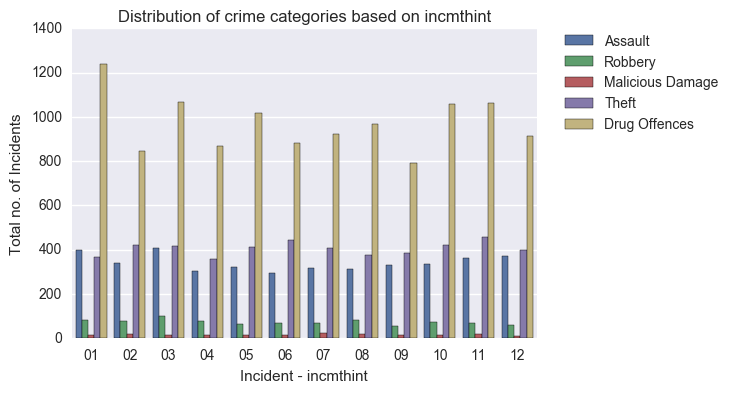

incday


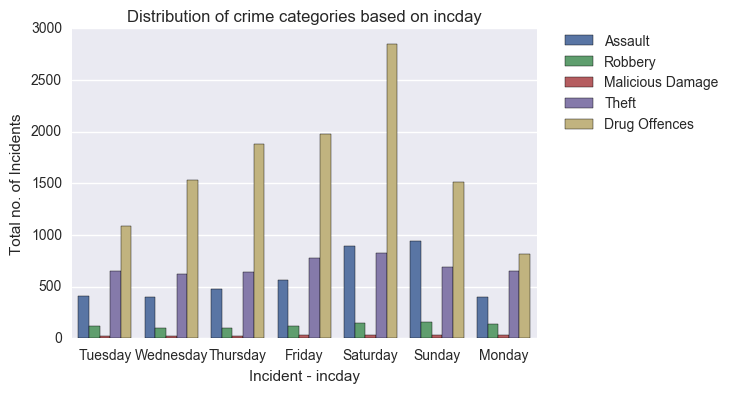

incsttm_zone


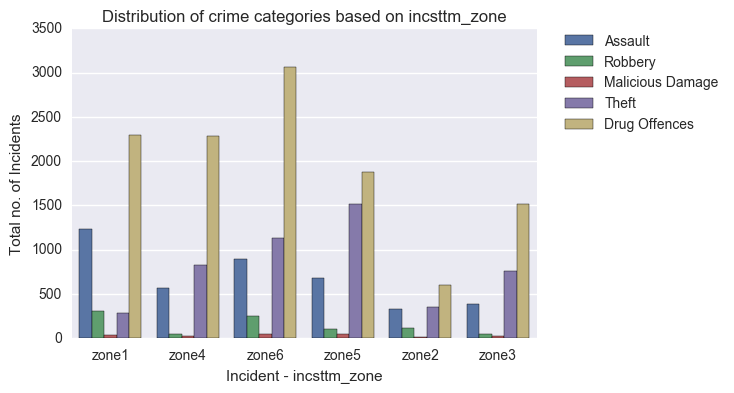

bcsrgccde


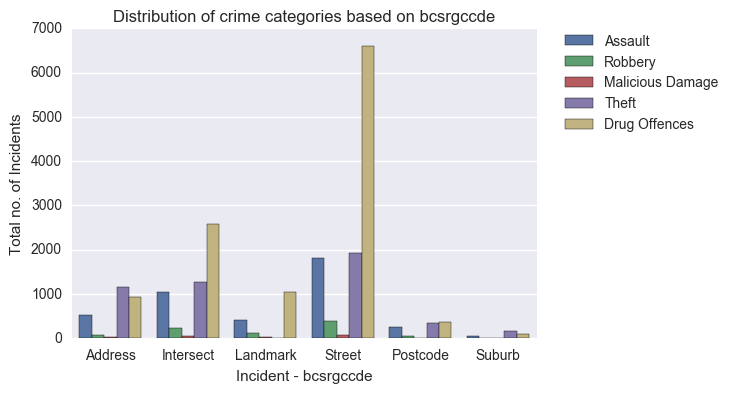

In [30]:
sns.set(style="darkgrid")

for i in list(['incmthint','incday','incsttm_zone','bcsrgccde']):
    print(i)
    sns.countplot(x=i, data=train,orient='v',hue='bcsrgrp')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Distribution of crime categories based on '+(i))
    plt.xlabel("Incident - "+i)
    plt.ylabel("Total no. of Incidents")
    plt.savefig(i+'.png', bbox_inches='tight')
    plt.show()

In [19]:
train['poisex'].replace([' '],['U'],inplace=True)
test['poisex'].replace([' '],['U'],inplace=True)


C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


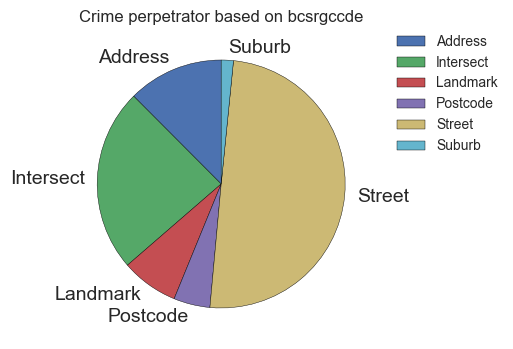

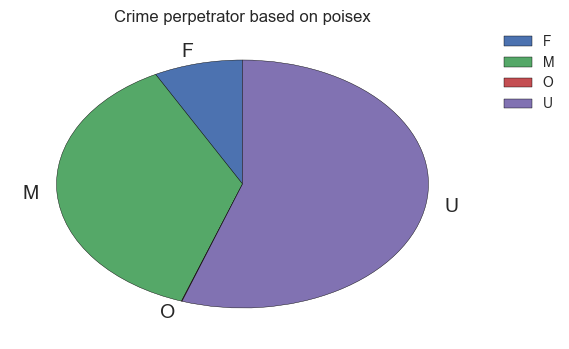

In [20]:
sns.set(style="darkgrid")
ax1 = plt.subplot( aspect='equal')
for i in ['bcsrgccde','poisex']:
    ax=train.groupby([i]).size().plot.pie(y='poisex',fontsize=14,startangle=90, shadow=False)
    plt.title('Crime perpetrator based on '+i)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(figsize=(16,8))
    ax.set_ylabel('')
    plt.savefig('Crime perpetrator based on '+i+'.png')
    plt.show()
    

In [21]:
def plot_unstack(df):
    for i in df.incyear.unique():
        df[df['incyear']==i].groupby(['incmthkey','bcsrgrp']).size().unstack().plot(kind='line',alpha=0.75)
        plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))
        fig = plt.figure()
        plt.show()

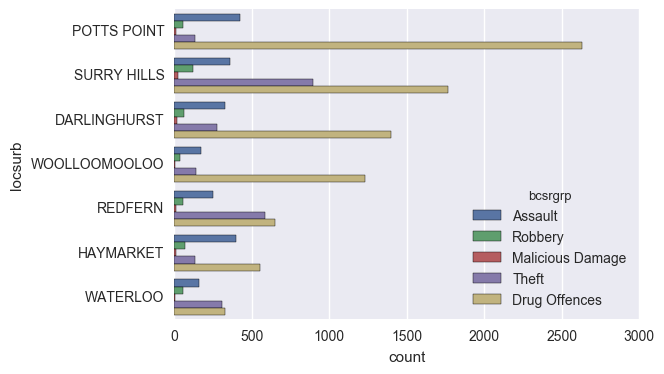

In [22]:
sns.set(style="darkgrid")
sns.countplot(y='locsurb',data=df[df['locsurb']!='SYDNEY'],orient='v',hue='bcsrgrp',order=df[df['locsurb']!='SYDNEY'].locsurb.value_counts().iloc[:7].index)

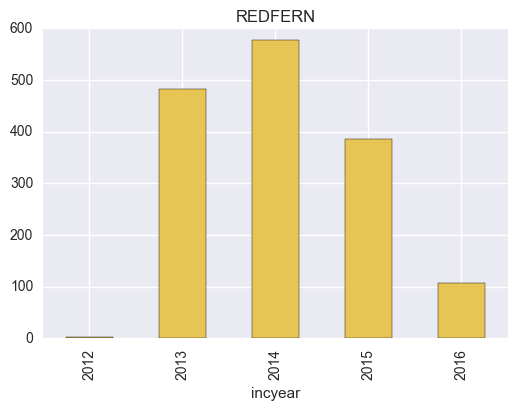

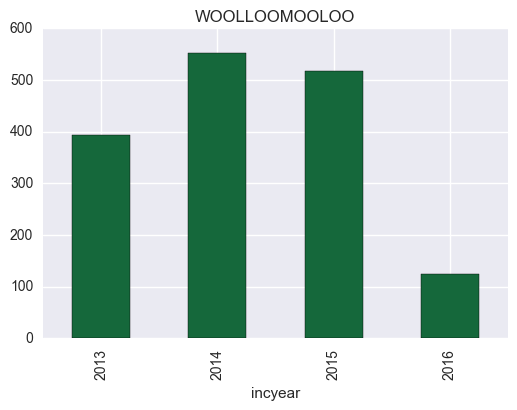

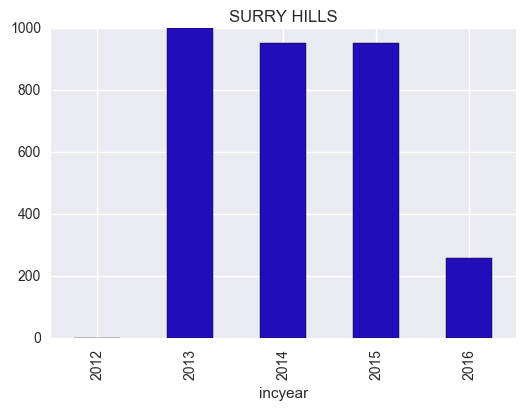

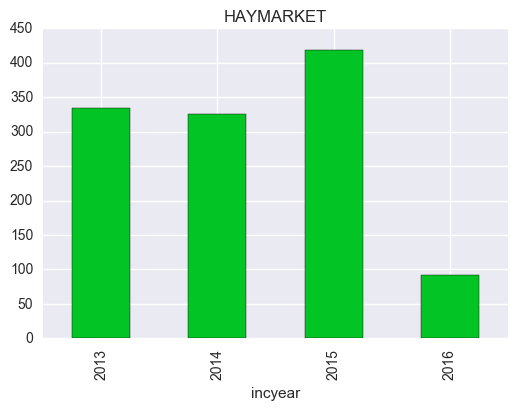

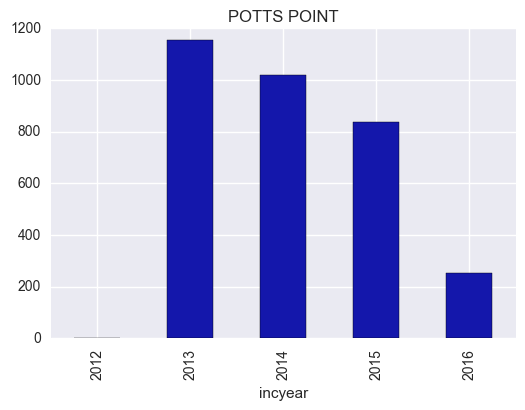

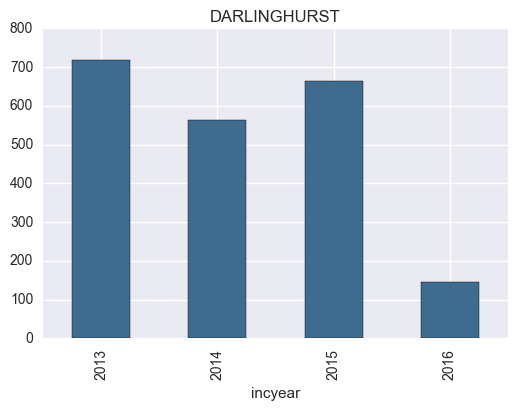

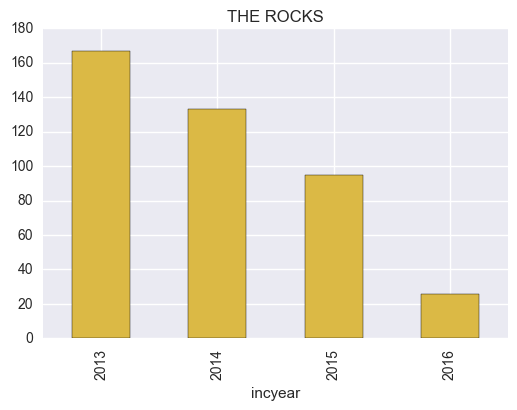

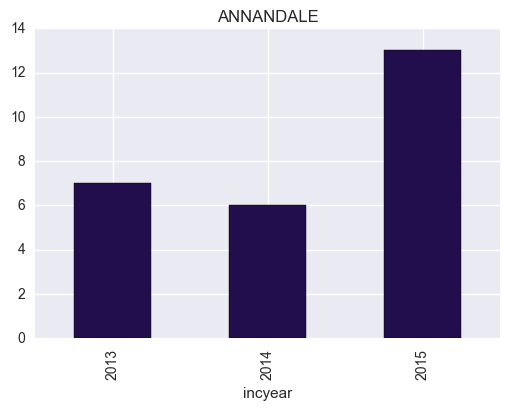

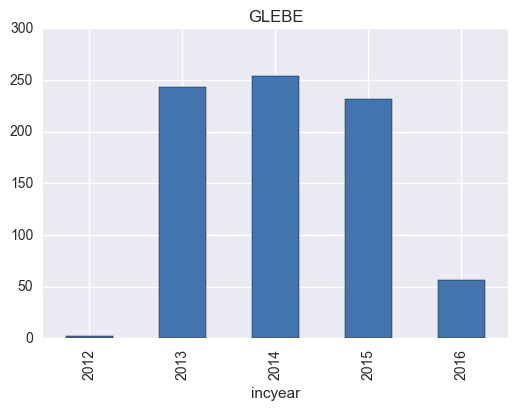

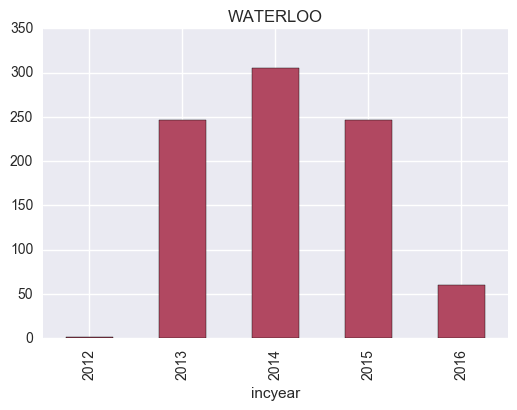

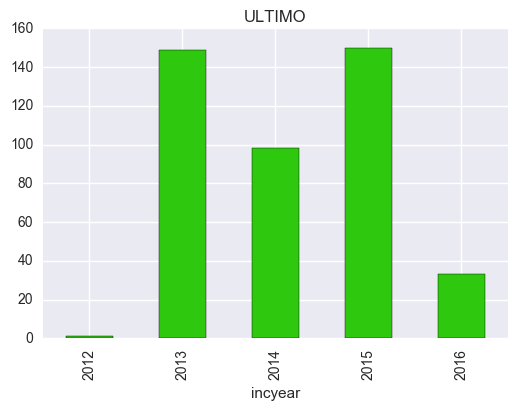

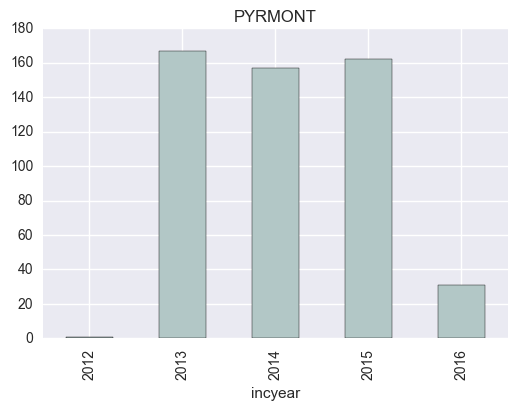

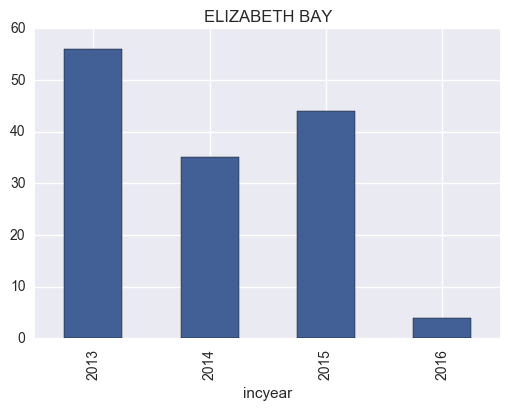

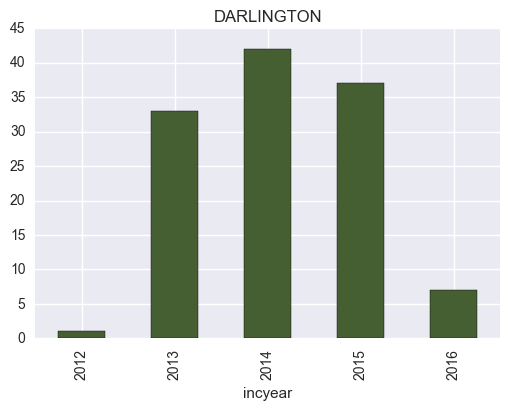

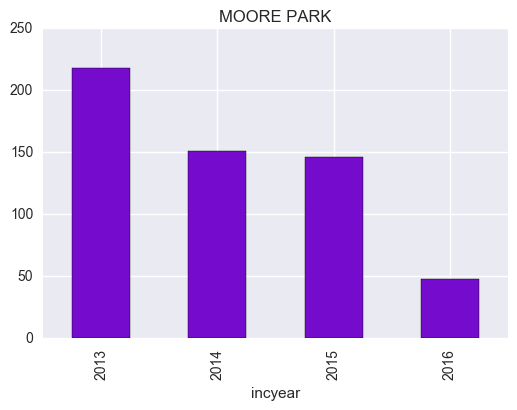

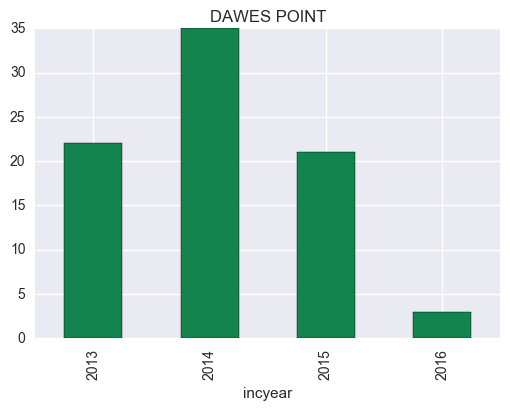

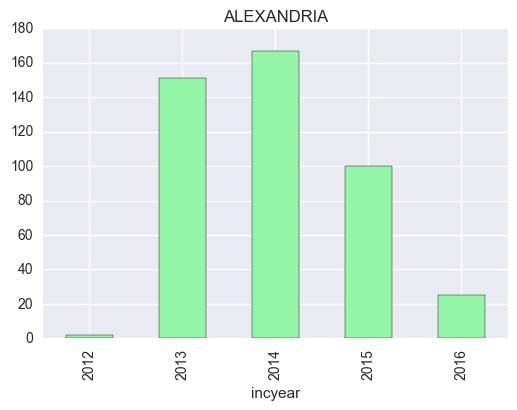

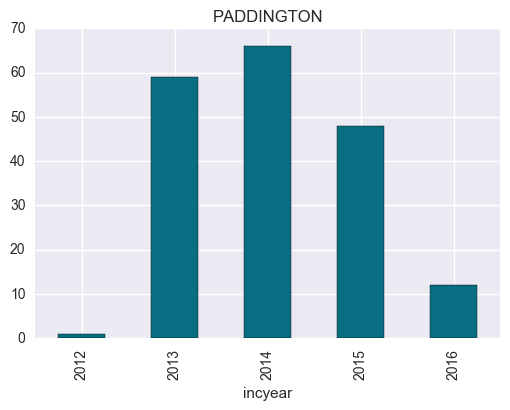

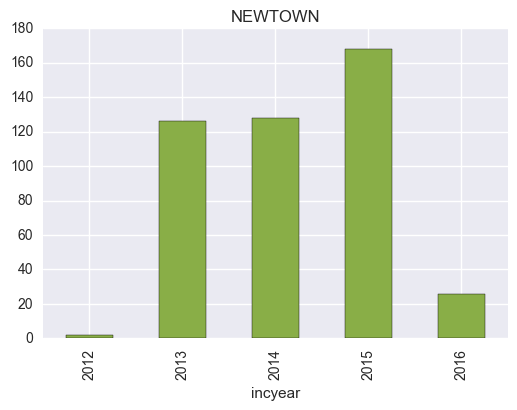

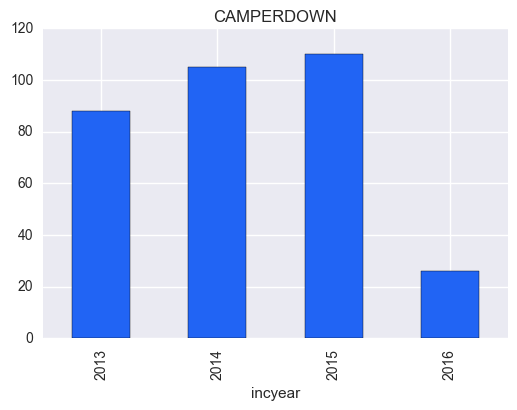

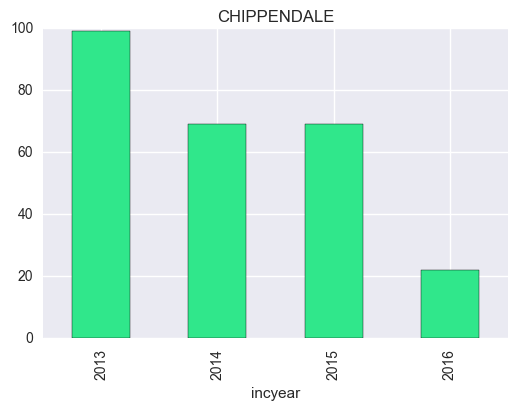

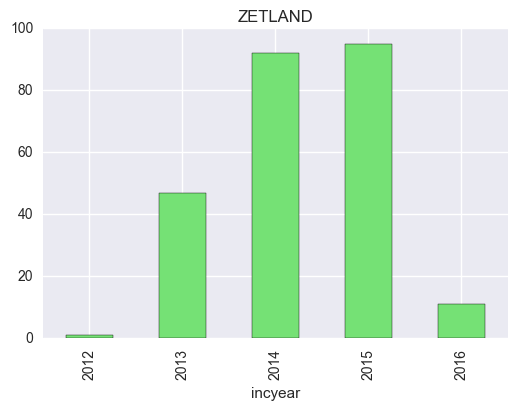

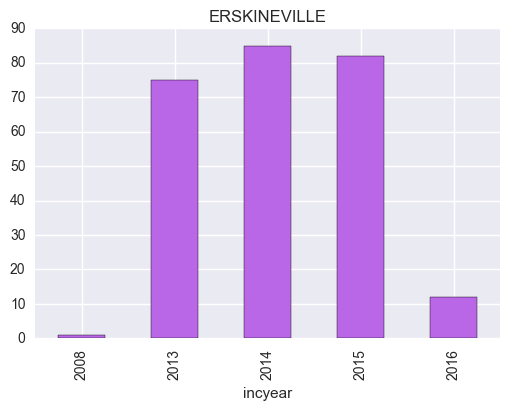

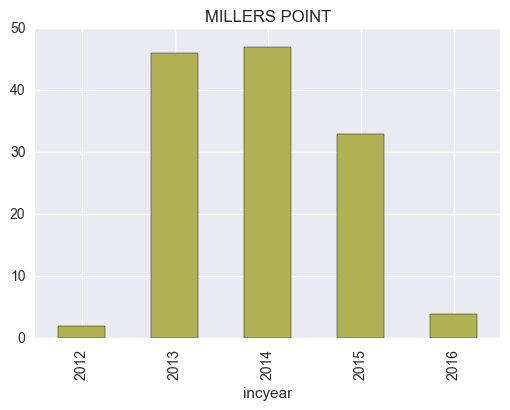

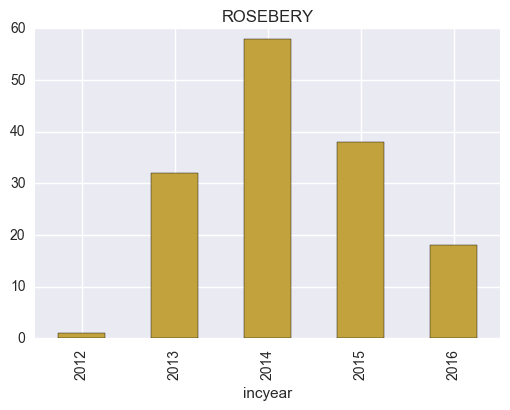

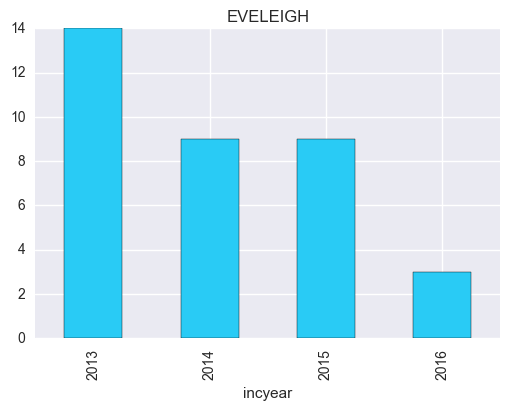

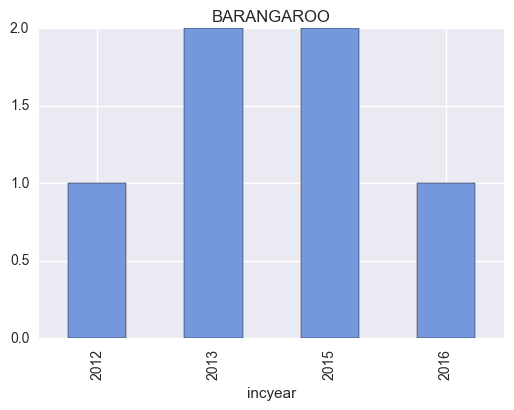

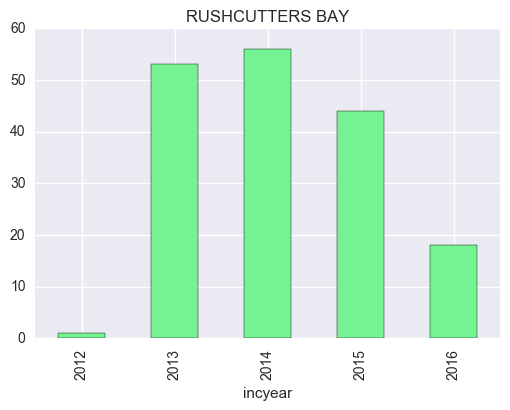

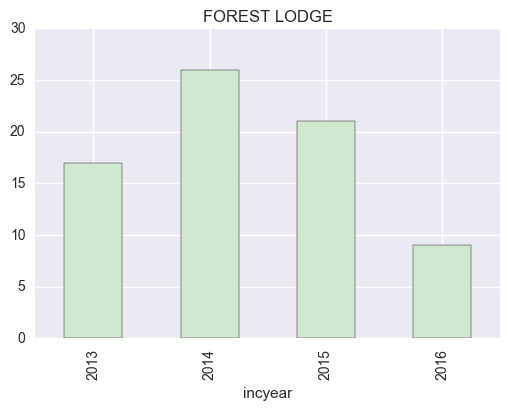

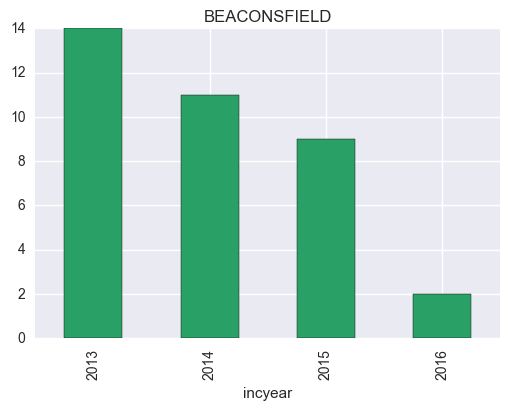

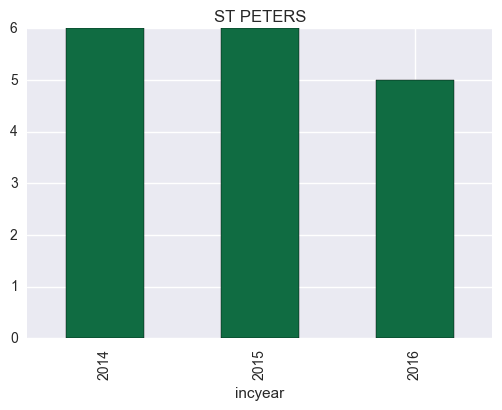

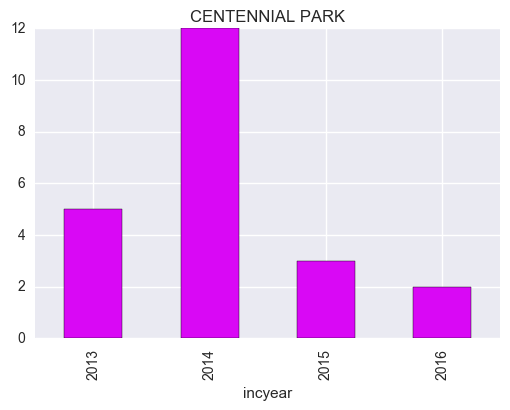

In [28]:
for i in df[df['locsurb']!='SYDNEY'].locsurb.unique():
    df[(df['locsurb']==i) & (df['locsurb']!='SYDNEY')].groupby(['incyear']).size().plot(kind='bar',alpha=1,color=np.random.rand(3,1))
    plt.title(i)
    plt.show()

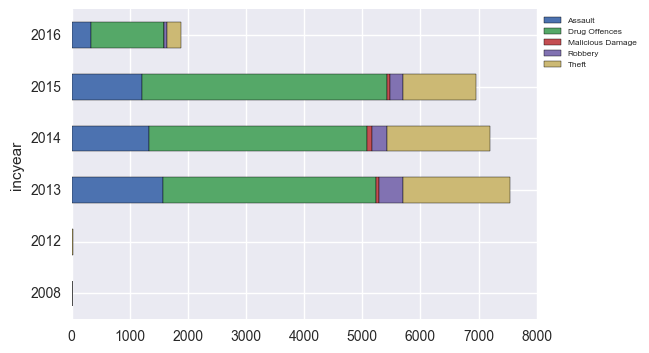

In [29]:
table=pd.pivot_table(df,values='FID',index=['incyear'],aggfunc=np.size,columns='bcsrgrp')
table.plot(kind='barh',stacked='True')
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))
plt.figure(figsize=(80, 40), dpi= 80, facecolor='w', edgecolor='k')
plt.show()

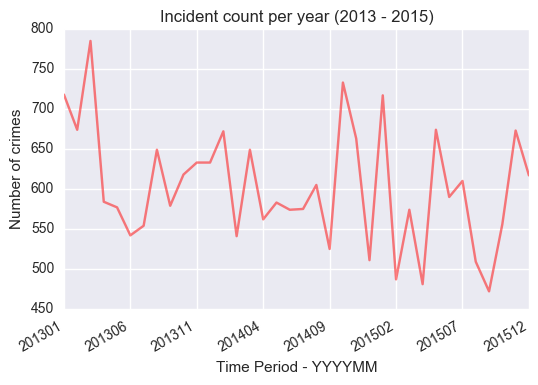

In [32]:
sns.set(style="darkgrid")
df_4=train[train['incmthkey']>='2013'].groupby(['incmthkey']).size()

df_4.plot(kind='line',legend=False,color='r',alpha=0.5)
plt.title('Incident count per year (2013 - 2015)')
plt.xlabel('Time Period - YYYYMM')
plt.ylabel('Number of crimes')
plt.gcf().autofmt_xdate()
plt.show()

In [35]:
#Model Building Begin with random forest


In [58]:
#we will take the incidents occured in year 2016 as test data set
test=df[df.incyear==2016]
train=df[(df.incyear>=2013)&(df.incyear<2016)]

In [59]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(df))
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 23605
Number of observations in the training data: 21699
Number of observations in the test data: 1878


In [60]:
train.columns


Index(['FID', 'OBJECTID', 'bcsrgrp', 'bcsrcat', 'lganame', 'locsurb',
       'locprmc1', 'locpcode', 'bcsrgclat', 'bcsrgclng', 'bcsrgccde',
       'incyear', 'incmonth', 'incday', 'incsttm', 'eventyr', 'eventmth',
       'poisex', 'poi_age', 'uniqueID'],
      dtype='object')

In [61]:
train_copy=train

In [62]:
train['bcsrgrp'].replace(['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],[1,2,3,4,5],inplace=True)
test['bcsrgrp'].replace(['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],[1,2,3,4,5],inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [63]:
#output variables to be trained and predicted
y_train=train['bcsrgrp']
y_test=test['bcsrgrp']

In [64]:
print('train bcsrgrp unique value are now:', train['bcsrgrp'].unique())
print('test bcsrgrp unique value are now:', test['bcsrgrp'].unique())

train bcsrgrp unique value are now: [1 2 3 4 5]
test bcsrgrp unique value are now: [1 2 3 4 5]


In [65]:
train.drop(['FID', 'OBJECTID','lganame','locprmc1','locpcode','bcsrgclat','bcsrgclng','uniqueID','bcsrcat','eventyr','poisex','poi_age','bcsrcat','incyear','eventmth'],axis=1,inplace=True)
test.drop(['FID', 'OBJECTID','lganame','locprmc1','locpcode','bcsrgclat','bcsrgclng','uniqueID','bcsrcat','eventyr','poi_age','poisex','bcsrcat','incyear','eventmth'],axis=1,inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [66]:
print(train.columns)
len(train.columns)


Index(['bcsrgrp', 'locsurb', 'bcsrgccde', 'incmonth', 'incday', 'incsttm'], dtype='object')


6

In [67]:
print(test.columns)
len(test.columns)

Index(['bcsrgrp', 'locsurb', 'bcsrgccde', 'incmonth', 'incday', 'incsttm'], dtype='object')


6

In [68]:
low_cardinality_cols = [cname for cname in train.columns if 
                                train[cname].nunique() < 40 and
                                train[cname].dtype == "object"]
numeric_cols = [cname for cname in train.columns if 
                                train[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = train[my_cols]
test_predictors = test[my_cols]

In [69]:
train_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21699 entries, 2 to 23400
Data columns (total 5 columns):
locsurb      21699 non-null object
bcsrgccde    21699 non-null object
incmonth     21699 non-null object
incday       21699 non-null object
bcsrgrp      21699 non-null int64
dtypes: int64(1), object(4)
memory usage: 1017.1+ KB


In [70]:
test_predictors.isnull().sum()

locsurb      0
bcsrgccde    0
incmonth     0
incday       0
bcsrgrp      0
dtype: int64

In [71]:
print(train_predictors.columns)
print(len(train_predictors.columns))
print(test_predictors.columns)
print(len(test_predictors.columns))
#use location ,area where incident occurs,month day,event month(this should be same as inc month but does not add value,time group(zone))

Index(['locsurb', 'bcsrgccde', 'incmonth', 'incday', 'bcsrgrp'], dtype='object')
5
Index(['locsurb', 'bcsrgccde', 'incmonth', 'incday', 'bcsrgrp'], dtype='object')
5


In [72]:
#time to drop the test prediction
test_predictors.drop(['bcsrgrp'],axis=1,inplace=True)


C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [73]:
print("shape of training set",train_predictors.shape)
print("shape of test set",test_predictors.shape)

shape of training set (21699, 5)
shape of test set (1878, 4)


In [74]:
train_objs_num = len(train_predictors)
dataset = pd.concat(objs=[train_predictors, test_predictors], axis=0)
dataset = pd.get_dummies(dataset)
train_new = dataset[:train_objs_num]
test_new = dataset[train_objs_num:]

In [75]:
print((train_new).shape)
print((test_new).shape)


(21699, 59)
(1878, 59)


In [76]:
test_new.drop(['bcsrgrp'],axis=1,inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [219]:
# one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

# one_hot_encoded_testing_predictors = pd.get_dummies(test_predictors)


In [77]:
# print((one_hot_encoded_training_predictors).shape)
# print((one_hot_encoded_testing_predictors).shape)


In [221]:
# final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_testing_predictors,
#                                                                     join='inner', 
#                                                                     axis=1)


In [223]:
#check to see all valid columns in test contain null values
final_train.columns[final_train.isnull().any()].tolist()

[]

In [78]:
# check to see all valid columns in test contain null values
# final_test.columns[final_test.isnull().any()].tolist()

In [79]:
print(train_new.shape)
print(test_new.shape)

(21699, 59)
(1878, 58)


In [81]:
test_new.isnull().sum()

bcsrgccde_Address          0
bcsrgccde_Intersect        0
bcsrgccde_Landmark         0
bcsrgccde_Postcode         0
bcsrgccde_Street           0
bcsrgccde_Suburb           0
incday_Friday              0
incday_Monday              0
incday_Saturday            0
incday_Sunday              0
incday_Thursday            0
incday_Tuesday             0
incday_Wednesday           0
incmonth_April             0
incmonth_August            0
incmonth_December          0
incmonth_February          0
incmonth_January           0
incmonth_July              0
incmonth_June              0
incmonth_March             0
incmonth_May               0
incmonth_November          0
incmonth_October           0
incmonth_September         0
locsurb_ALEXANDRIA         0
locsurb_ANNANDALE          0
locsurb_BARANGAROO         0
locsurb_BEACONSFIELD       0
locsurb_CAMPERDOWN         0
locsurb_CENTENNIAL PARK    0
locsurb_CHIPPENDALE        0
locsurb_DARLINGHURST       0
locsurb_DARLINGTON         0
locsurb_DAWES 

In [82]:
# # Choose simple fillna instead of imputer with most frequent
# imp=Imputer(strategy='mean')
# final_train=imp.fit_transform(final_train)
# final_test=imp.transform(final_test)
# # final_test=final_test.fillna(0)

In [86]:
train_new_copy=train_new

In [87]:
train_new.drop(['bcsrgrp'],axis=1,inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [88]:
clf = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=1000)
clf.fit(train_new,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
pred_vals=clf.predict(test_new)

In [90]:
pred_vals

array([4, 1, 4, ..., 5, 4, 5], dtype=int64)

In [91]:
y_test.head()

4838    1
4839    1
4840    1
4841    1
4842    1
Name: bcsrgrp, dtype: int64

In [92]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_vals)

0.57028753993610226

In [93]:
y_test_list=list(y_test)
pred_vals_list=list(pred_vals)

In [95]:
print (len(y_test_list))
print(len(pred_vals_list))

1878
1878


In [96]:
test['actual_values']=y_test_list
test['predicted_values']=pred_vals_list

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [97]:
test.shape

(1878, 8)

In [98]:
test['actual_values'].replace([1,2,3,4,5],['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],inplace=True)
test['predicted_values'].replace([1,2,3,4,5],['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [101]:

test[test['actual_values']==test['predicted_values']].groupby(['locsurb','actual_values','predicted_values']).size()

locsurb          actual_values  predicted_values
ALEXANDRIA       Assault        Assault               1
                 Drug Offences  Drug Offences         2
                 Theft          Theft                13
BEACONSFIELD     Theft          Theft                 2
CAMPERDOWN       Assault        Assault               1
                 Drug Offences  Drug Offences         7
                 Robbery        Robbery               1
                 Theft          Theft                 2
CENTENNIAL PARK  Theft          Theft                 2
CHIPPENDALE      Assault        Assault               1
                 Drug Offences  Drug Offences         3
                 Theft          Theft                 3
DARLINGHURST     Assault        Assault               2
                 Drug Offences  Drug Offences        82
                 Theft          Theft                 1
DAWES POINT      Drug Offences  Drug Offences         2
                 Theft          Theft                 1

In [102]:

test[test['actual_values']!=test['predicted_values']].groupby(['locsurb','actual_values','predicted_values']).size()

locsurb        actual_values     predicted_values
ALEXANDRIA     Assault           Theft                2
               Drug Offences     Assault              1
                                 Theft                4
               Malicious Damage  Assault              1
                                 Drug Offences        1
BARANGAROO     Malicious Damage  Drug Offences        1
CAMPERDOWN     Assault           Drug Offences        1
                                 Theft                1
               Drug Offences     Theft               10
               Malicious Damage  Assault              1
               Theft             Drug Offences        2
CHIPPENDALE    Assault           Drug Offences        1
                                 Theft                3
               Drug Offences     Assault              2
                                 Theft                4
               Robbery           Theft                2
               Theft             Assault              

In [103]:
print("Total Predictions : ",len(test))
print("Correct Predictions : ",len(test[test['actual_values']==test['predicted_values']]))
print("Incorrect Predictions : ",len(test[test['actual_values']!=test['predicted_values']]))

Total Predictions :  1878
Correct Predictions :  1071
Incorrect Predictions :  807
